## Problem Statement

This project aims to build a collaborative filtering-based recommendation system using machine learning. Recommendation systems are crucial in filtering relevant content for users, especially in large datasets such as movies, music, or products.

## Dataset Overview

The **MovieLens** dataset contains:
- User information and their movie ratings.
- Movie metadata including titles and genres.

**Source**: [MovieLens Dataset](https://grouplens.org/datasets/movielens/)
**Variables**:
- `userId` (Numeric): Unique identifier for users.
- `movieId` (Numeric): Unique identifier for movies.
- `rating` (Numeric): Rating given by a user to a movie, ranging from 0.5 to 5.
- `timestamp` (Numeric): The time of the rating, useful for potential time-based analysis.





# Load and preprocess data



In [1]:
! curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   749k      0  0:00:01  0:00:01 --:--:--  749k


In [2]:
import zipfile

zip_path = '/content/ml-latest-small.zip'

# Open the ZIP file in read mode
with open(zip_path, 'rb') as zip_file:  # Open the file in binary read mode
    # Create a ZipFile object using the open file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('/content/')

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# Load and preprocess data
movies = pd.read_csv('/content/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')

In [5]:
movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [7]:
ratings.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [9]:
# Print the number of movies
print("Number of Movies:", len(movies))

# Print the number of unique users
print("Number of Users:", len(np.unique(ratings['userId'])))

# Print the unique rating categories
print("Rating Categories:", np.unique(ratings['rating']))

Number of Movies: 9742
Number of Users: 610
Rating Categories: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


In [10]:
ratings['rating'].value_counts()

,count
rating,
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791


# Data Summary and Visualization

Missing values in the dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


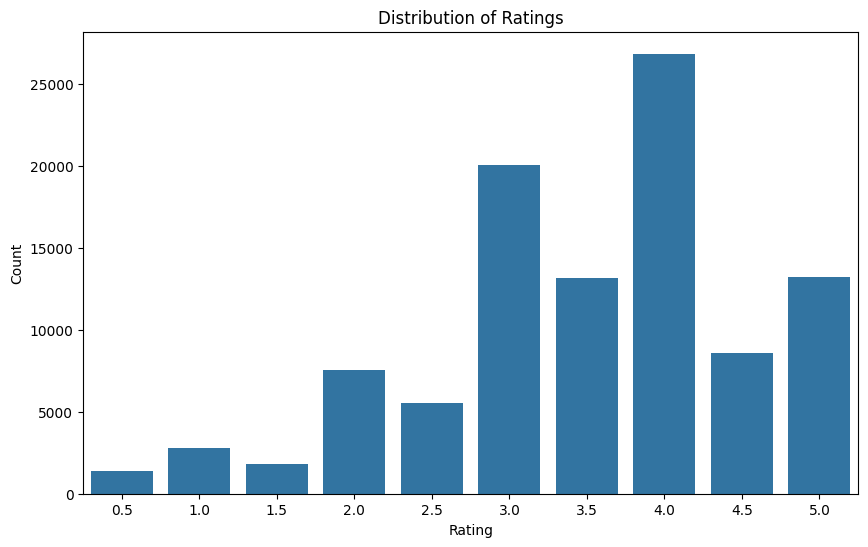

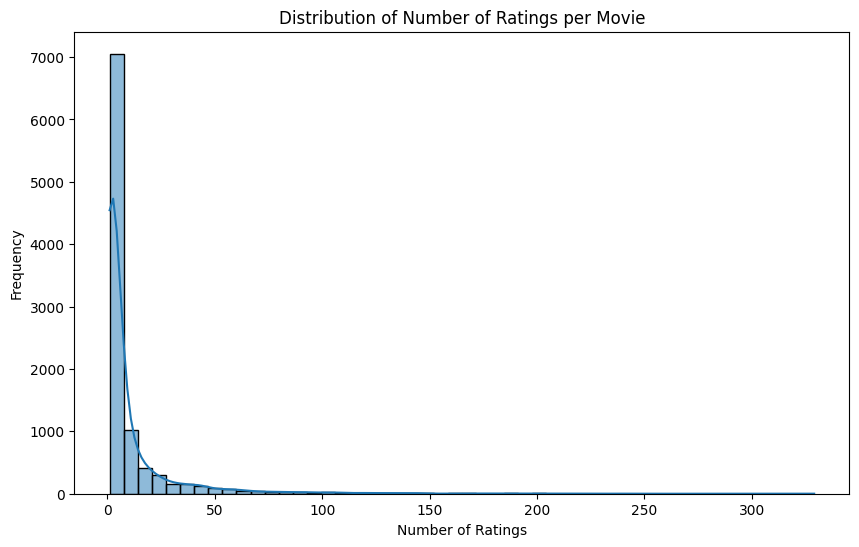

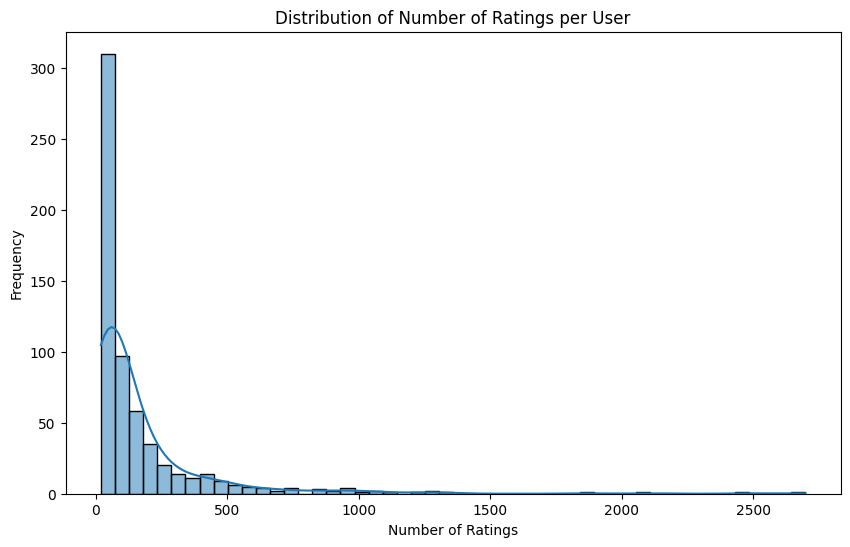

In [11]:
# Importing required libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print("Missing values in the dataset:")
print(ratings.isnull().sum())
print(movies.isnull().sum())

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title("Distribution of Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

# Number of ratings per user
ratings_per_user = ratings.groupby('userId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()


# Data Preprocessing

## Feature Selection
For collaborative filtering, each user’s rating of items represents the primary feature. Since our data primarily consists of user-movie ratings, additional feature engineering or selection is limited.


In [12]:
# Create user-movie ratings matrix
ratings_matrix = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)
ratings_matrix
# Normalize ratings to [0, 1] range
scaler = MinMaxScaler()
ratings_scaled = scaler.fit_transform(ratings_matrix)

# Convert to torch tensors
ratings_tensor = torch.FloatTensor(ratings_scaled)

In [13]:
print(ratings_tensor)

tensor([[0.8000, 0.0000, 0.8000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5000, 0.4000, 0.4000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


# RBM Model

In [14]:
class GaussianBernoulliRBM(nn.Module):
    def __init__(self, visible_units, hidden_units, sigma=1.0):
        """
        Gaussian-Bernoulli RBM

        Parameters:
        - visible_units: number of visible units (number of movies)
        - hidden_units: number of hidden units
        - sigma: standard deviation for Gaussian visible units
        """
        super(GaussianBernoulliRBM, self).__init__()

        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.sigma = sigma

        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.1)
        self.v_bias = nn.Parameter(torch.zeros(visible_units))
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))

    def sample_h(self, v):
        """Sample hidden units given visible units"""
        activation = F.linear(v / self.sigma, self.W, self.h_bias)
        p_h = torch.sigmoid(activation)
        return p_h, torch.bernoulli(p_h)

    def sample_v(self, h):
        """Sample visible units given hidden units"""
        activation = F.linear(h, self.W.t(), self.v_bias)
        # For Gaussian units, we directly sample from Normal distribution
        v_mean = activation
        v_sample = v_mean + torch.randn_like(v_mean) * self.sigma
        return v_mean, v_sample

    def free_energy(self, v):
        """Calculate free energy"""
        v_term = 0.5 * torch.sum((v - self.v_bias) ** 2 / self.sigma**2, dim=1)
        wx_b = F.linear(v / self.sigma, self.W, self.h_bias)
        h_term = torch.sum(torch.log(1 + torch.exp(wx_b)), dim=1)
        return -h_term + v_term

    def forward(self, v):
        """Forward pass"""
        h_prob, h_sample = self.sample_h(v)
        v_prob, v_sample = self.sample_v(h_sample)
        return v_prob, v_sample

# Training function
def train_gaussian_rbm(model, train_data, epochs=10, batch_size=100, lr=0.01):
    """
    Train Gaussian-Bernoulli RBM using contrastive divergence
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)

    n_samples = train_data.shape[0]
    n_batches = n_samples // batch_size

    for epoch in range(epochs):
        epoch_loss = 0

        # Shuffle data at the start of each epoch
        indices = torch.randperm(n_samples)
        train_data = train_data[indices]

        for batch in range(n_batches):
            start = batch * batch_size
            end = start + batch_size
            batch_data = train_data[start:end]

            # Positive phase
            pos_hidden_prob, pos_hidden = model.sample_h(batch_data)

            # Negative phase (reconstruction)
            neg_visible_mean, neg_visible = model.sample_v(pos_hidden)
            neg_hidden_prob, neg_hidden = model.sample_h(neg_visible)

            # Calculate gradients
            positive_grad = torch.mm(pos_hidden.t(), batch_data / model.sigma)
            negative_grad = torch.mm(neg_hidden.t(), neg_visible / model.sigma)

            # Compute weight updates
            update = positive_grad - negative_grad

            optimizer.zero_grad()

            # Manual gradient updates
            model.W.grad = -(update - model.W * 0.0002) / batch_size  # Include L2 regularization
            model.v_bias.grad = -torch.mean(batch_data - neg_visible, 0) / model.sigma**2
            model.h_bias.grad = -torch.mean(pos_hidden - neg_hidden, 0)

            optimizer.step()

            # Calculate reconstruction error (MSE for Gaussian units)
            batch_loss = torch.mean((batch_data - neg_visible_mean) ** 2)
            epoch_loss += batch_loss.item()

        avg_epoch_loss = epoch_loss / n_batches
        print(f'Epoch {epoch+1}/{epochs} - Avg. Loss: {avg_epoch_loss:.4f}')


# Function to get movie recommendations for a user
def get_recommendations(model, user_ratings, n_recommendations=10):
    """
    Get movie recommendations for a user using Gaussian-Bernoulli RBM
    """
    user_tensor = torch.FloatTensor(user_ratings).unsqueeze(0)

    # Get hidden features
    _, hidden = model.sample_h(user_tensor)

    # Reconstruct ratings
    recommendations, _ = model.sample_v(hidden)
    recommendations = torch.clamp(recommendations, min=0)  # Ensure no negative ratings
    recommendations = recommendations.squeeze().detach().numpy()

    # Get movie indices that user hasn't rated
    unrated_movies = np.where(user_ratings == 0)[0]

    # Get top N recommendations from unrated movies
    recommended_indices = unrated_movies[np.argsort(recommendations[unrated_movies])[-n_recommendations:]]

    # Get movie information
    recommended_movies = movies[movies['movieId'].isin(ratings_matrix.columns[recommended_indices])]

    return recommended_movies

# Evaluation function
def evaluate_recommendations(model, test_data, k=10):
    """
    Evaluate the model using RMSE and Hit Rate@K
    """
    n_users = test_data.shape[0]
    mse_total = 0
    n_hits = 0

    for i in range(n_users):
        user_ratings = test_data[i]
        actual_movies = torch.where(user_ratings > 0)[0]

        if len(actual_movies) > 0:
            # Get recommendations
            user_tensor = user_ratings.unsqueeze(0)
            _, hidden = model.sample_h(user_tensor)
            predictions, _ = model.sample_v(hidden)
            predictions = predictions.squeeze()

            # Calculate MSE for non-zero ratings
            mse = torch.mean((user_ratings[actual_movies] - predictions[actual_movies]) ** 2)
            mse_total += mse.item()

            # Calculate Hit Rate@K
            top_k = torch.argsort(predictions)[-k:]
            if any(movie in top_k for movie in actual_movies):
                n_hits += 1

    rmse = np.sqrt(mse_total / n_users)
    hit_rate = n_hits / n_users

    return rmse, hit_rate



# Precision@K and Recall@K evaluation function
def precision_recall_at_k(model, test_data, k=10):
    """
    Evaluate the model using Precision@K and Recall@K
    """
    total_precision = 0
    total_recall = 0
    n_users = test_data.shape[0]

    for i in range(n_users):
        user_ratings = test_data[i].numpy()
        actual_movies = np.where(user_ratings > 0)[0]

        if len(actual_movies) > 0:
            user_tensor = torch.FloatTensor(user_ratings).unsqueeze(0)

            with torch.no_grad():
                if isinstance(model, GaussianBernoulliRBM):
                    # Unpack the output if it's a tuple
                    recommendations = model(user_tensor)[0] if isinstance(model(user_tensor), tuple) else model(user_tensor)
                    recommendations = recommendations.squeeze().numpy()  # Use v_prob from RBM
                else:
                    # Unpack the output if it's a tuple
                    recommendations = model(user_tensor)[0] if isinstance(model(user_tensor), tuple) else model(user_tensor)
                    recommendations = recommendations.squeeze().numpy()  # Use Autoencoder's output directly

            top_k = np.argsort(recommendations)[-k:]
            relevant_in_top_k = len([movie for movie in top_k if movie in actual_movies])

            precision_at_k = relevant_in_top_k / k
            recall_at_k = relevant_in_top_k / len(actual_movies)
            total_precision += precision_at_k
            total_recall += recall_at_k

    avg_precision_at_k = total_precision / n_users
    avg_recall_at_k = total_recall / n_users

    return avg_precision_at_k, avg_recall_at_k


# Train model

In [15]:
# Initialize and train model
visible_units = ratings_matrix.shape[1]
hidden_units = 100
sigma = 0.1  # Standard deviation for Gaussian visible units

model = GaussianBernoulliRBM(visible_units, hidden_units, sigma)

# Split data into train and test sets
train_data, test_data = train_test_split(ratings_tensor, test_size=0.2, random_state=42)

# Train the model
train_gaussian_rbm(model, train_data, epochs=300, batch_size=16, lr=0.001)

Epoch 1/300 - Avg. Loss: 0.2930
Epoch 2/300 - Avg. Loss: 0.2012
Epoch 3/300 - Avg. Loss: 0.1708
Epoch 4/300 - Avg. Loss: 0.1455
Epoch 5/300 - Avg. Loss: 0.1228
Epoch 6/300 - Avg. Loss: 0.1036
Epoch 7/300 - Avg. Loss: 0.0868
Epoch 8/300 - Avg. Loss: 0.0734
Epoch 9/300 - Avg. Loss: 0.0615
Epoch 10/300 - Avg. Loss: 0.0530
Epoch 11/300 - Avg. Loss: 0.0457
Epoch 12/300 - Avg. Loss: 0.0401
Epoch 13/300 - Avg. Loss: 0.0363
Epoch 14/300 - Avg. Loss: 0.0330
Epoch 15/300 - Avg. Loss: 0.0302
Epoch 16/300 - Avg. Loss: 0.0281
Epoch 17/300 - Avg. Loss: 0.0261
Epoch 18/300 - Avg. Loss: 0.0240
Epoch 19/300 - Avg. Loss: 0.0222
Epoch 20/300 - Avg. Loss: 0.0209
Epoch 21/300 - Avg. Loss: 0.0194
Epoch 22/300 - Avg. Loss: 0.0182
Epoch 23/300 - Avg. Loss: 0.0169
Epoch 24/300 - Avg. Loss: 0.0158
Epoch 25/300 - Avg. Loss: 0.0150
Epoch 26/300 - Avg. Loss: 0.0140
Epoch 27/300 - Avg. Loss: 0.0133
Epoch 28/300 - Avg. Loss: 0.0125
Epoch 29/300 - Avg. Loss: 0.0119
Epoch 30/300 - Avg. Loss: 0.0115
Epoch 31/300 - Avg.

In [16]:
# Pass the user tensor through the model
_, hidden = model.sample_h(ratings_tensor)  # Sample hidden features
predicted_ratings, _ = model.sample_v(hidden)  # Reconstruct visible layer to get predictions

# Clamp predictions to ensure no negative values
predicted_ratings = torch.clamp(predicted_ratings, min=0)

# Remove the batch dimension and convert to numpy for easier visualization
predicted_ratings = torch.FloatTensor(predicted_ratings.squeeze().detach())

# Display the original and predicted tensors side-by-side
print("Original Ratings (with 0s as missing values):")
print(ratings_tensor)
print("Predicted Ratings (filled in for missing values):")
print(predicted_ratings)


Original Ratings (with 0s as missing values):
tensor([[0.8000, 0.0000, 0.8000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5000, 0.4000, 0.4000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
Predicted Ratings (filled in for missing values):
tensor([[3.6035e-01, 2.0533e-01, 3.1845e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.1743e-01, 5.9677e-02,
         3.3872e-02],
        [0.0000e+00, 4.7011e-02, 0.0000e+00,  ..., 1.4228e-02, 0.0000e+00,
         3.4809e-02],
        ...,
        [2.8817e-01, 2.5280e-01, 1.9688e-01,  ..., 5.4897e-03, 0.0000e+00,
         3.4480e-02],
        [3.5631e-01, 4.4185e-02, 0.0000e+00,  ..., 1.3352e-02, 0.0000e+00,
         4.2171e-03],
        

#Evaluate model

In [17]:
# Evaluate model
rmse, hit_rate = evaluate_recommendations(model, test_data)
print(f"\nModel Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"Hit Rate@10: {hit_rate:.4f}")

avg_precision, avg_recall = precision_recall_at_k(model, test_data, k=10)
print(f"Average Precision@10: {avg_precision}")
print(f"Average Recall@10: {avg_recall}")



Model Evaluation:
RMSE: 0.5641
Hit Rate@10: 0.9672
Average Precision@10: 0.7655737704918034
Average Recall@10: 0.10357736003642364


In [18]:
# Example: Get recommendations for a specific user
def show_recommendations_for_user(user_id, n_recommendations=10):
    """Show movie recommendations for a specific user"""
    user_ratings = ratings_scaled[ratings_matrix.index == user_id].squeeze()
    recommendations = get_recommendations(model, user_ratings, n_recommendations)

    print(f"\nTop {n_recommendations} recommendations for user {user_id}:")
    for _, movie in recommendations.iterrows():
        print(f"- {movie['title']}")

# 3. Get recommendations for a specific user
user_id = ratings_matrix.index[0]  # First user in the dataset
show_recommendations_for_user(user_id)

user_id = ratings_matrix.index[1]  # First user in the dataset
show_recommendations_for_user(user_id)

user_id = ratings_matrix.index[5]  # First user in the dataset
show_recommendations_for_user(user_id)


Top 10 recommendations for user 1:
- Babe (1995)
- Happy Gilmore (1996)
- Terminator 2: Judgment Day (1991)
- Godfather, The (1972)
- Aliens (1986)
- Godfather: Part II, The (1974)
- Stand by Me (1986)
- Breakfast Club, The (1985)
- Sixth Sense, The (1999)
- Christmas Story, A (1983)

Top 10 recommendations for user 2:
- Silence of the Lambs, The (1991)
- Saving Private Ryan (1998)
- Matrix, The (1999)
- Kill Bill: Vol. 2 (2004)
- Gran Torino (2008)
- Hangover, The (2009)
- Avengers, The (2012)
- Argo (2012)
- Deadpool (2016)
- The Martian (2015)

Top 10 recommendations for user 6:
- Clueless (1995)
- Judge Dredd (1995)
- Quiz Show (1994)
- Beverly Hills Cop III (1994)
- Demolition Man (1993)
- RoboCop 3 (1993)
- Nightmare Before Christmas, The (1993)
- Heavy Metal (1981)
- James and the Giant Peach (1996)
- Eraser (1996)


# search Box enter userID ,get the top 10 recommendation


In [19]:
import ipywidgets as widgets
from IPython.display import display

def interactive_recommendations(user_id):
    try:
        # Get user ratings
        user_ratings = ratings_scaled[ratings_matrix.index == user_id].squeeze()

        # Call get_recommendations with user_ratings and other necessary arguments
        recommendations = get_recommendations(model, user_ratings, n_recommendations=10) # Assuming 'model' is defined and accessible

        # Display recommendations (no need to call show_recommendations_for_user)
        print(f"Top 10 recommendations for User {user_id}:")
        for idx, (_, movie) in enumerate(recommendations.iterrows(), 1): # Iterate through dataframe rows
            print(f"{idx}. {movie['title']}")

    except KeyError:
        print(f"User ID {user_id} not found. Please try a valid User ID.")

# Create the input box
user_id_input = widgets.Text(
    value='',
    placeholder='Enter User ID',
    description='User ID:',
    disabled=False
)

# Display the button and the function call
display(user_id_input)

user_id_input.on_submit(lambda x: interactive_recommendations(int(x.value)))

Text(value='', description='User ID:', placeholder='Enter User ID')

# Hyperparameter Tuning for the GaussianBernoulliRBM Model


In [20]:
# Define a grid search function for RBM parameters
def grid_search_rbm(train_data, test_data, hidden_units_list, learning_rates, epochs=30, batch_size=100):
    best_model = None
    best_hit_rate = 0
    best_precision = 0
    best_recall = 0
    best_hidden_units = None
    best_lr = None

    for hidden_units in hidden_units_list:
        for lr in learning_rates:
            # Initialize the RBM model with the current hidden units and learning rate
            model = GaussianBernoulliRBM(visible_units=train_data.shape[1], hidden_units=hidden_units, sigma=0.1)

            # Train the RBM model
            train_gaussian_rbm(model, train_data, epochs=epochs, batch_size=batch_size, lr=lr)

            # Evaluate the model's Hit Rate@10 and RMSE
            _, hit_rate = evaluate_recommendations(model, test_data, k=10)
            avg_precision, avg_recall = precision_recall_at_k(model, test_data, k=10)

            # Print evaluation metrics for the current configuration
            print(f"Hidden Units: {hidden_units}, Learning Rate: {lr}")
            print(f"Hit Rate@10: {hit_rate:.4f}, Precision@10: {avg_precision:.4f}, Recall@10: {avg_recall:.4f}\n")

            # Update best model if current hit rate is better than previous best
            if hit_rate > best_hit_rate:
                best_hit_rate = hit_rate
                best_precision = avg_precision
                best_recall = avg_recall
                best_model = model
                best_hidden_units = hidden_units
                best_lr = lr

    # Output the best model and its performance metrics
    print(f"Best GaussianBernoulliRBM Model with Hit Rate@10: {best_hit_rate:.4f}, Precision@10: {best_precision:.4f}, Recall@10: {best_recall:.4f}")
    print(f"Optimal Parameters - Hidden Units: {best_hidden_units}, Learning Rate: {best_lr}")

    return best_model, best_hit_rate, best_precision, best_recall, best_hidden_units, best_lr

# Execute grid search
hidden_units_list = [100, 200, 300]
learning_rates = [0.01, 0.005, 0.001]
best_rbm_model, best_hit_rate, best_precision, best_recall, best_hidden_units, best_lr = grid_search_rbm(train_data, test_data, hidden_units_list, learning_rates)



Epoch 1/30 - Avg. Loss: 0.3589
Epoch 2/30 - Avg. Loss: 0.2701
Epoch 3/30 - Avg. Loss: 0.2046
Epoch 4/30 - Avg. Loss: 0.1643
Epoch 5/30 - Avg. Loss: 0.1334
Epoch 6/30 - Avg. Loss: 0.1083
Epoch 7/30 - Avg. Loss: 0.0868
Epoch 8/30 - Avg. Loss: 0.0709
Epoch 9/30 - Avg. Loss: 0.0575
Epoch 10/30 - Avg. Loss: 0.0476
Epoch 11/30 - Avg. Loss: 0.0395
Epoch 12/30 - Avg. Loss: 0.0340
Epoch 13/30 - Avg. Loss: 0.0293
Epoch 14/30 - Avg. Loss: 0.0274
Epoch 15/30 - Avg. Loss: 0.0270
Epoch 16/30 - Avg. Loss: 0.0273
Epoch 17/30 - Avg. Loss: 0.0273
Epoch 18/30 - Avg. Loss: 0.0267
Epoch 19/30 - Avg. Loss: 0.0251
Epoch 20/30 - Avg. Loss: 0.0219
Epoch 21/30 - Avg. Loss: 0.0204
Epoch 22/30 - Avg. Loss: 0.0181
Epoch 23/30 - Avg. Loss: 0.0161
Epoch 24/30 - Avg. Loss: 0.0153
Epoch 25/30 - Avg. Loss: 0.0139
Epoch 26/30 - Avg. Loss: 0.0133
Epoch 27/30 - Avg. Loss: 0.0123
Epoch 28/30 - Avg. Loss: 0.0119
Epoch 29/30 - Avg. Loss: 0.0118
Epoch 30/30 - Avg. Loss: 0.0108
Hidden Units: 100, Learning Rate: 0.01
Hit Rate@1